# Cuaderno de cálculos y gráficas

In [1]:
# Import modules
import ipywidgets
import numpy as np
import pandas as pd
import logging
import glob
import os

# All the stuffs for the processing of MI
import processing as pr

# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt

# Signal processing
import scipy.signal as snl
from scipy.io import wavfile
import scipy.stats as stats

 2020-05-22 15:53:32,816 - DEBUG - Define classes and functions.


In [2]:
%matplotlib inline

 2020-05-22 15:21:44,192 - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
import logging
logging.disable(logging.CRITICAL)

In [3]:
with open("MI_rel.dat", "r") as f:
    line = f.readline()
    MI_rel = eval(line)

In [4]:
bands = list(MI_rel.keys())
channels = list(MI_rel["delta"].keys())

In [5]:
with open("MI_rel_ds8.dat", "r") as f:
    line = f.readline()
    MI_rel_ds8 = eval(line)

In [6]:
mi_folder = "../Data/mutualinfo/"
mi_files = glob.glob(mi_folder + "*.mi")
mi_files.sort()
ds8_files = glob.glob(mi_folder + "ds8/*.mi")
ds8_files.sort()

In [7]:
file = mi_files[0]
name = os.path.split(file)[1].split(".")[0] + "_ds8.mi"
try:
    assert((mi_folder + "ds8/" + name) in ds8_files)
except:
    print(name + " NOT FOUND.")
mi = pr.MutualInformation(1,2,3,4,5,True,file)
ds8 = pr.MutualInformation(1,2,3,4,5,True,mi_folder+"ds8/"+name)

KeyError: ':'

In [ ]:
fandp = {}
for band in bands:
    fandp[band] = {}
    for channel in channels:
        for file in mi_files:
            name = os.path.split(mi_files[0])[1].split(".")[0] + "_ds8.mi"
            try:
                assert((mi_folder + "ds8/" + name) in ds8_files)
            except:
                print(name + " NOT FOUND.")
            mi = pr.MutualInformation(1,2,3,4,5,True,file)
            ds8 = pr.MutualInformation(1,2,3,4,5,True,mi_filder+"ds8/"+name)
        data = []
        data_
        fval, pval = stats.f_oneway()

## Plotting part

In [7]:
fig = plt.figure()

bands = list(MI_rel.keys())
k = bands[0]
labels = list(MI_rel[k].keys())
mi_rel_vals = list(MI_rel[k].values())
ds8_rel_vals = list(MI_rel_ds8[k].values())

<Figure size 432x288 with 0 Axes>

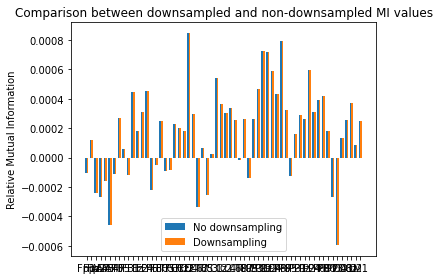

In [9]:
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mi_rel_vals, width, label='No downsampling')
rects2 = ax.bar(x + width/2, ds8_rel_vals, width, label='Downsampling')

ax.set_ylabel('Relative Mutual Information')
ax.set_title('Comparison between downsampled and non-downsampled MI values')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


fig.tight_layout()

plt.show()